# Introduction to this python notebook

In [ ]:
"""
What? ICA = Independent component analysis

Reference: https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py
"""

# Import python modules

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import signal
from sklearn.decomposition import FastICA, PCA

# Example #1

## Generate sample data

In [3]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations


## Create ICA & PCA

In [4]:
"""
An example of estimating sources from noisy data. Independent component analysis (ICA) is used to estimate 
sources given noisy measurements. Imagine 3 instruments playing simultaneously and 3 microphones recording
the mixed signals.
"""

'\nAn example of estimating sources from noisy data. Independent component analysis (ICA) is used to estimate \nsources given noisy measurements. Imagine 3 instruments playing simultaneously and 3 microphones recording\nthe mixed signals.\n'

In [5]:
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

## Plotting

In [6]:
"""
ICA is used to recover the sources ie. what is played by each instrument. Importantly, PCA fails at recovering 
our instruments since the related signals reflect non-Gaussian processes.
"""

'\nICA is used to recover the sources ie. what is played by each instrument. Importantly, PCA fails at recovering \nour instruments since the related signals reflect non-Gaussian processes.\n'

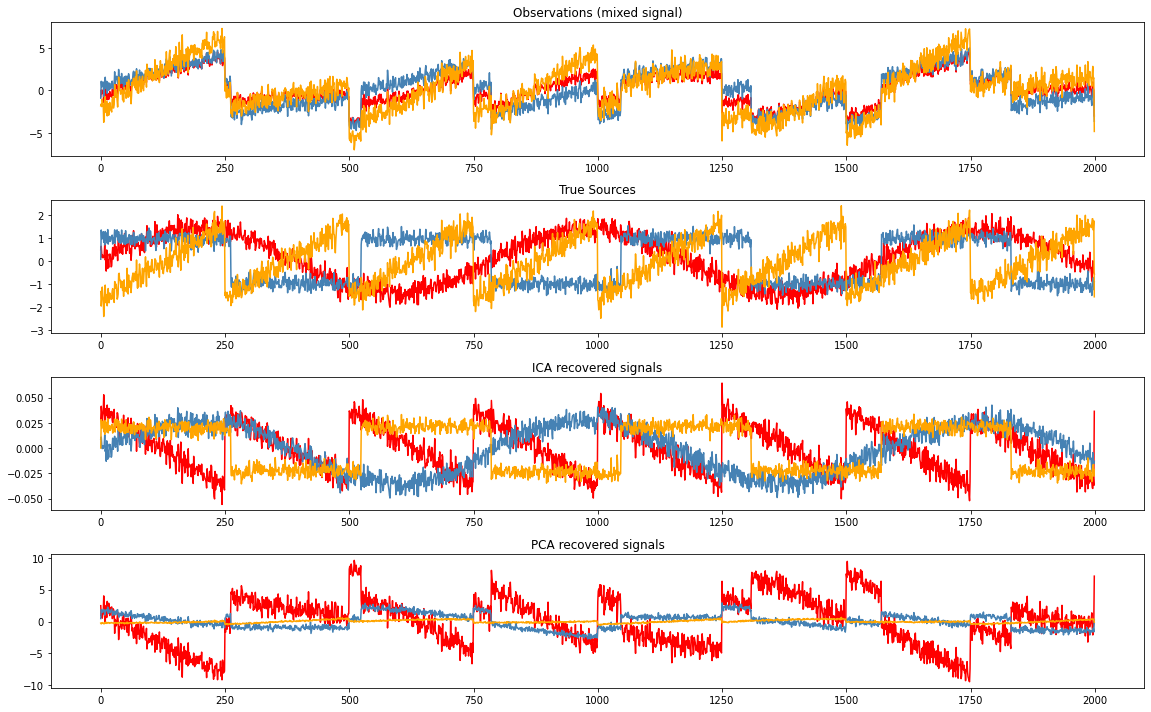

In [7]:
plt.figure(figsize=(16,10))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

# Example #2

In [ ]:
"""
Representing ICA in the feature space gives the view of ‘geometric ICA’: ICA is an algorithm that finds directions 
in the feature space corresponding to projections with high non-Gaussianity. These directions need not be orthogonal
in the original feature space, but they are orthogonal in the whitened feature space, in which all directions 
correspond to the same variance.

PCA, on the other hand, finds orthogonal directions in the raw feature space that correspond to directions accounting
for maximum variance. PCA is a probabilistic models. 
"""

## Generate data

In [8]:
# Generate sample data
rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.

# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations

pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

S_ica_ /= S_ica_.std(axis=0)

## Plotting

In [9]:
def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver((0, 0), (0, 0), x_axis, y_axis, zorder=11, width=0.01,
                       scale=6, color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

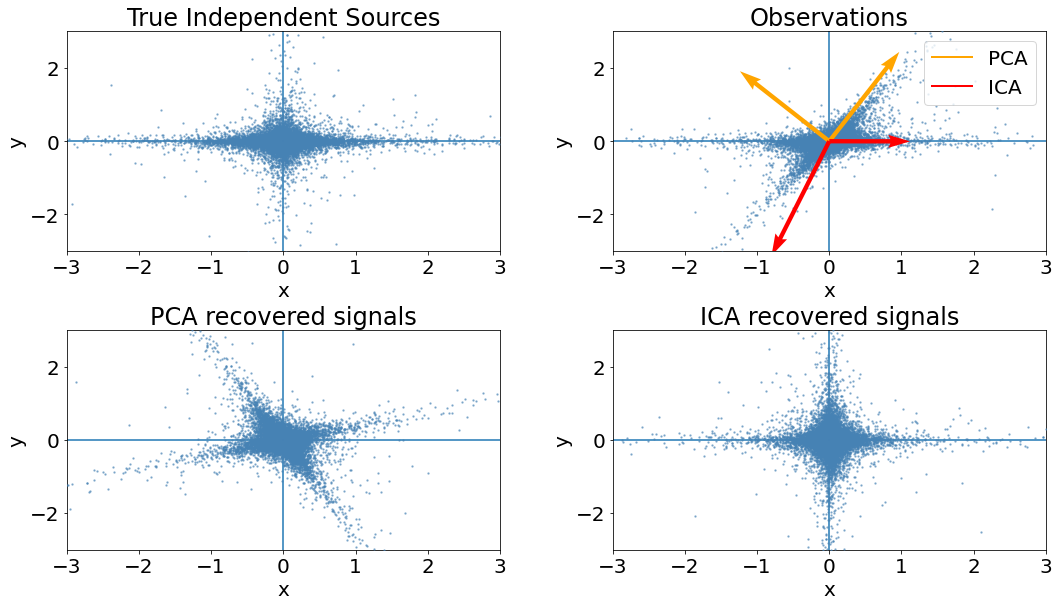

In [17]:
plt.figure(figsize=(16,8))
rcParams['font.size'] = 20

plt.subplot(2, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()

In [ ]:
"""
Here we simulate independent sources using a highly non-Gaussian process, 2 student T with a low number of 
degrees of freedom (top left figure). We mix them to create observations (top right figure). In this raw 
observation space, directions identified by PCA are represented by orange vectors. 

We represent the signal in the PCA space, after whitening by the variance corresponding to the PCA vectors 
(lower left). Running ICA corresponds to finding a rotation in this space to identify the directions of 
largest non-Gaussianity (lower right).
"""